In [2]:

import numpy as np # for random number distributions
import pandas as pd # for event_log data frame
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10)
import queue # add FIFO queue data structure
from functools import partial, wraps
import os
import random

import simpy # discrete event simulation environment

In [3]:
'''        
---------------------------------------------------------
set up event tracing of all simulation program events 
controlled by the simulation environment
that is, all timeout and process events that begin with "env."
documentation at:
  https://simpy.readthedocs.io/en/latest/topical_guides/monitoring.html#event-tracing
  https://docs.python.org/3/library/functools.html#functools.partial
'''
def trace(env, callback):
     """Replace the ``step()`` method of *env* with a tracing function
     that calls *callbacks* with an events time, priority, ID and its
     instance just before it is processed.
     note: "event" here refers to simulaiton program events

     """
     def get_wrapper(env_step, callback):
         """Generate the wrapper for env.step()."""
         @wraps(env_step)
         def tracing_step():
             """Call *callback* for the next event if one exist before
             calling ``env.step()``."""
             if len(env._queue):
                 t, prio, eid, event = env._queue[0]
                 callback(t, prio, eid, event)
             return env_step()
         return tracing_step

     env.step = get_wrapper(env.step, callback)

def trace_monitor(data, t, prio, eid, event):
     data.append((t, eid, type(event)))

def test_process(env):
     yield env.timeout(1)

'''
---------------------------------------------------------
set up an event log for recording events
as defined for the discrete event simulation
we use a list of tuples for the event log
documentation at:
  https://simpy.readthedocs.io/en/latest/topical_guides/monitoring.html#event-tracing
'''     
def event_log_append(env, caseid, time, activity, event_log):
    event_log.append((caseid, time, activity))
    yield env.timeout(0)

In [4]:
### Define class for customer with attributes

class Customer:
    def __init__(self, arrival_time,caseid, order_size, is_takeout,sim_params):
        self.arrival_time = arrival_time
        self.caseid = caseid
        self.order_size = order_size
        self.is_takeout = is_takeout
        self.min_patience = sim_params['MIN_PATIENCE']
        self.max_patience = sim_params['MAX_PATIENCE']
        self.wait_time = 0  # Initialize wait start time
        self.wait = 1  # Initialize wait flag

        # calculate party_size based on order_size
        if self.is_takeout:
            self.party_size = 1
        else:
            self.party_size = self.order_size

        # function to update wait given delta time
    def update_wait_time(self, d_time):
        self.wait_time += d_time

### define function cooking process

def cook(env, customer, sim_params):
    # cook time is normally distributed with mean and std dev
    cook_time = np.random.normal(sim_params['COOK_TIME_MEAN'], sim_params['COOK_TIME_STD_DEV'])

    # if cook time is negative, set to 0
    if cook_time < 0:
        cook_time = 0
    

    # if customer is still waiting, update wait time
    if customer.wait > 0:
        customer.update_wait(cook_time)

    # if waiting is longer than patience, leave and abort cooking and meal is lost
    # else cook for cook_time
    if customer.wait_time > customer.max_patience:
        print('Customer was impatient', customer.caseid, 'left at', env.now)
        meal_lost = 1
        return meal_lost
    else:
        # print cook time
        print('Cooking for customer', customer.caseid, 'for', cook_time, 'minutes')
        yield env.timeout(cook_time)
        return 1




In [5]:
### Arrival and in the queue waiting process

def arrival_waiting(env, sim_params, resources, caseid_queue_dinein, caseid_queue_takeout, event_log):
    caseid = 0
    customers = []
    meal_lost = 0
    meal_lost_list = []

    while True:
        inter_arrival_time = round(60 * np.random.exponential(scale=sim_params['ARRIVAL_RATE']))
        
        print("NEXT ARRIVAL TIME: ", env.now + inter_arrival_time)
        yield env.timeout(inter_arrival_time)
        caseid += 1
        
        # create a new customer 
        customer = Customer(env.now, caseid, np.random.randint(1, 5), np.random.choice([True, False]), sim_params)
        customers.append(customer)
        
        time = env.now
        
        activity = 'arrival'
        env.process(event_log_append(env, caseid, time, activity, event_log))
        yield env.timeout(0)

        if np.random.random() < sim_params['DINE_IN_PROB']:
            # Dine-in customer
            if caseid_queue_dinein.qsize() < sim_params['MAX_QUEUE_LENGTH']:
                caseid_queue_dinein.put(caseid)
                print("Customer joins dine-in queue caseid =", caseid, 'time =', env.now, 'queue_length =', caseid_queue_dinein.qsize())
                time = env.now
                activity = 'join_queue_dinein'
                env.process(event_log_append(env, caseid, time, activity, event_log))
                env.process(dinein_service_process(env, sim_params, resources, caseid_queue_dinein, event_log))
            else:
                print("Dine-in customer balks caseid =", caseid, 'time =', env.now, 'queue_length =', caseid_queue_dinein.qsize())
                env.process(event_log_append(env, caseid, env.now, 'balk_dinein', event_log))
        else:
            # Takeout customer
            if caseid_queue_takeout.qsize() < sim_params['MAX_QUEUE_LENGTH']:
                caseid_queue_takeout.put(caseid)
                print("Customer joins takeout queue caseid =", caseid, 'time =', env.now, 'queue_length =', caseid_queue_takeout.qsize())
                time = env.now
                activity = 'join_queue_takeout'
                env.process(event_log_append(env, caseid, time, activity, event_log))
                env.process(takeout_service_process(env, sim_params, resources, caseid_queue_takeout, event_log))
            else:
                print("Takeout customer balks caseid =", caseid, 'time =', env.now, 'queue_length =', caseid_queue_takeout.qsize())
                env.process(event_log_append(env, caseid, env.now, 'balk_takeout', event_log))


### Dine-in process

def dinein_service_process(env, sim_params, resources, caseid_queue, event_log):
    with resources['tables'].request() as table, resources['servers'].request() as server:
        caseid = caseid_queue.get()
        patience = random.uniform(sim_params['MIN_PATIENCE'], sim_params['MAX_PATIENCE'])
        
        for item in event_log:
            if item[2] == 'arrival' and item[0] == caseid:
                arrive = item[1]
                break
        
        wait = env.now - arrive
        results = yield table | env.timeout(patience)
        
        if table in results:
            results = yield server | env.timeout(patience)
            
            if server in results:
                print("Customer seated and served caseid =", caseid, 'time =', env.now, 'wait =', wait)
                time = env.now
                activity = 'seated'
                env.process(event_log_append(env, caseid, time, activity, event_log))
                
                activity = 'served'
                env.process(event_log_append(env, caseid, time, activity, event_log))
                
                activity = 'eating'
                yield env.timeout(sim_params['DINEIN_SERVICE_TIME'])
                
                time = env.now
                activity = 'finished_eating'
                env.process(event_log_append(env, caseid, time, activity, event_log))
                print("Customer finished eating caseid =", caseid, 'time =', env.now)
                
                activity = 'paying'
                env.process(event_log_append(env, caseid, time, activity, event_log))
                yield env.timeout(sim_params['PAYMENT_TIME'])
                
                time = env.now
                activity = 'leaving'
                env.process(event_log_append(env, caseid, time, activity, event_log))
                yield env.timeout(0)
            else:
                print("Customer left due to impatience caseid =", caseid, 'time =', env.now)
                time = env.now
                activity = 'impatience'
                env.process(event_log_append(env, caseid, time, activity, event_log))


## Take-out process

def takeout_service_process(env, sim_params, resources, caseid_queue, event_log):
    with resources['cooks'].request() as cook:
        caseid = caseid_queue.get()
        patience = random.uniform(sim_params['MIN_PATIENCE'], sim_params['MAX_PATIENCE'])
        
        for item in event_log:
            if item[2] == 'arrival' and item[0] == caseid:
                arrive = item[1]
                break
        
        wait = env.now - arrive
        results = yield cook | env.timeout(patience)
        
        if cook in results:
            print("Takeout order being prepared caseid =", caseid, 'time =', env.now, 'wait =', wait)
            time = env.now
            activity = 'cooking'
            env.process(event_log_append(env, caseid, time, activity, event_log))
            
            yield env.timeout(sim_params['TAKEOUT_SERVICE_TIME'])
            
            time = env.now
            activity = 'finished_takeout'
            env.process(event_log_append(env, caseid, time, activity, event_log))
            print("Takeout order finished caseid =", caseid, 'time =', env.now)
            
            time = env.now
            activity = 'leaving_takeout'
            env.process(event_log_append(env, caseid, time, activity, event_log))
            yield env.timeout(0)
        else:
            print("Takeout customer left due to impatience caseid =", caseid, 'time =', env.now)
            time = env.now
            activity = 'impatience'
            env.process(event_log_append(env, caseid, time, activity, event_log))

In [6]:
## Restaurant Simulation Constants

# Resources
NUM_SERVERS = 1  # Number of servers
NUM_COOKS = 2  # Number of cooks in the kitchen
NUM_TABLES = 10  # Number of tables in the restaurant
NUM_TAKEOUT_QUEUE = 5  # Number of people that can be queued for takeout before balk
NUM_DINEIN_QUEUE = 5  # Number of people that can be queued for dine-in before balk


# Probabilities parameters
DINE_IN_PROB = 0.5  # Probability that a customer will dine in
TAKEOUT_PROB = 1 - DINE_IN_PROB  # Probability that a customer will order takeout

# Parameters for the simulation
SIMULATION_TIME = 480  # Total simulation time in minutes (e.g., 8 hours)

# Parameters for the customers
MIN_PATIENCE = 1  # Minimum time a customer will wait before leaving
MAX_PATIENCE = 2  # Maximum time a customer will wait before leaving
MIN_SEATING_TIME = 1  # Minimum time a customer will spend eating
MAX_SEATING_TIME = 5  # Maximum time a customer will spend eating

DINEIN_SERVICE_TIME = 5  # Average service time for dine-in customers (e.g., 5 minutes)
BASE_SERVICE_RATE = 1 / 4  # Base service rate for dine-in customers (e.g., service time of 4 minutes)

TAKEOUT_SERVICE_TIME = 3  # Average service time for takeout customers (e.g., 3 minutes)
TAKEOUT_SERVICE_RATE = 1 / 3  # Service rate for takeout orders (e.g., service time of 3 minutes)

PAYMENT_TIME = 1  # Average time for a customer to pay their bill (e.g., 2 minutes)

# Queue parameters
ARRIVAL_RATE = 1 / 5  # Average arrival rate for dine-in (e.g., 1 customer every 5 minutes)
MAX_QUEUE_LENGTH = 5  # Maximum number of customers that can be in the queue before balking

# Cook parameters
COOK_TIME = 10  # Average time to cook an order and clean kitchen (e.g., 10 minutes per order)
KITCHEN_COOK_RATE = 1 / 10  # Average time to cook an order (e.g., 10 minutes per order)

# Wage and revenue  parameters
SERVER_WAGE = 15  # Hourly wage for servers
COOK_WAGE = 15  # Hourly wage for cooks
REVENUE_PER_DINEIN = 30  # Average revenue per dine-in customer
REVENUE_PER_TAKEOUT = 20  # Average revenue per takeout customer

# Random Seed
RANDOM_SEED = 42

# Number of simulation replications
NUM_SIMULATIONS = 100

OBTAIN_REPRODUCIBLE_RESULTS = True

# dictionary of simulation parameters listed above
sim_params = {
    'NUM_SERVERS': NUM_SERVERS,
    'NUM_COOKS': NUM_COOKS,
    'NUM_TABLES': NUM_TABLES,
    'NUM_TAKEOUT_QUEUE': NUM_TAKEOUT_QUEUE,
    'NUM_DINEIN_QUEUE': NUM_DINEIN_QUEUE,
    'DINE_IN_PROB': DINE_IN_PROB,
    'TAKEOUT_PROB': TAKEOUT_PROB,
    'SIMULATION_TIME': SIMULATION_TIME,
    'MIN_PATIENCE': MIN_PATIENCE,
    'MAX_PATIENCE': MAX_PATIENCE,
    'MIN_SEATING_TIME': MIN_SEATING_TIME,
    'MAX_SEATING_TIME': MAX_SEATING_TIME,
    'DINEIN_SERVICE_TIME': DINEIN_SERVICE_TIME,
    'BASE_SERVICE_RATE': BASE_SERVICE_RATE,
    'TAKEOUT_SERVICE_TIME': TAKEOUT_SERVICE_TIME,
    'TAKEOUT_SERVICE_RATE': TAKEOUT_SERVICE_RATE,
    'PAYMENT_TIME': PAYMENT_TIME,
    'ARRIVAL_RATE': ARRIVAL_RATE,
    'MAX_QUEUE_LENGTH': MAX_QUEUE_LENGTH,
    'COOK_TIME': COOK_TIME,
    'KITCHEN_COOK_RATE': KITCHEN_COOK_RATE,
    'SERVER_WAGE': SERVER_WAGE,
    'COOK_WAGE': COOK_WAGE,
    'REVENUE_PER_DINEIN': REVENUE_PER_DINEIN,
    'REVENUE_PER_TAKEOUT': REVENUE_PER_TAKEOUT,
    'RANDOM_SEED': RANDOM_SEED,
    'NUM_SIMULATIONS': NUM_SIMULATIONS,
    'OBTAIN_REPRODUCIBLE_RESULTS': OBTAIN_REPRODUCIBLE_RESULTS
}

In [7]:
### Simulation Environment

'''
---------------------------------------
set up the SimPy simulation environment
and run the simulation with monitoring
---------------------------------------
'''
if OBTAIN_REPRODUCIBLE_RESULTS: 
    np.random.seed(RANDOM_SEED)


# set up simulation trace monitoring for the simulation
data = []
# bind *data* as first argument to monitor()
this_trace_monitor = partial(trace_monitor, data)

env = simpy.Environment()
trace(env, this_trace_monitor)


p = env.process(test_process(env))

env.run(until=p)

for d in data:
    print(d)



(0, 0, <class 'simpy.events.Initialize'>)
(1, 1, <class 'simpy.events.Timeout'>)
(1, 2, <class 'simpy.events.Process'>)


In [8]:
env = simpy.Environment()

# implement FIFO queue to hold caseid values
caseid_queue_dinein = queue.Queue()
caseid_queue_takeout = queue.Queue()

# set up limited resource: Tables, Waiters, Cooks

# tables are a limited resource
available_tables = simpy.Resource(env, capacity = NUM_TABLES)

# servers are a limited resource
available_servers = simpy.Resource(env, capacity = NUM_SERVERS)

# cooks are a limited resource
available_cooks = simpy.Resource(env, capacity = NUM_COOKS)

# dictionary of resources
resources = {
    'tables': available_tables,
    'servers': available_servers,
    'cooks': available_cooks
}


caseid = -1  # dummy caseid for beginning of simulation
# dummy caseid values will be omitted from the event_log
# prior to analyzing simulation results

# beginning record in event_log list of tuples of the form
# form of the event_log tuple item: (caseid, time, activity)

event_log = [(caseid,0,'null_start_simulation')]

# event_monitor = partial(event_monitor, event_log)
env.process(event_log_append(env, caseid, env.now, 'start_simulation', event_log))
 
# call customer arrival process/generator to begin the simulation
env.process(arrival_waiting(env, sim_params, resources, caseid_queue_dinein, caseid_queue_takeout, event_log))  

env.run(until = sim_params['SIMULATION_TIME'])  # start simulation with monitoring and fixed end-time

NEXT ARRIVAL TIME:  6
Customer joins takeout queue caseid = 1 time = 6 queue_length = 1
NEXT ARRIVAL TIME:  17
Takeout order being prepared caseid = 1 time = 6 wait = 0
Takeout order finished caseid = 1 time = 9
Customer joins dine-in queue caseid = 2 time = 17 queue_length = 1
NEXT ARRIVAL TIME:  18
Customer seated and served caseid = 2 time = 17 wait = 0
Customer joins takeout queue caseid = 3 time = 18 queue_length = 1
NEXT ARRIVAL TIME:  33
Takeout order being prepared caseid = 3 time = 18 wait = 0
Takeout order finished caseid = 3 time = 21
Customer finished eating caseid = 2 time = 22
Customer joins takeout queue caseid = 4 time = 33 queue_length = 1
NEXT ARRIVAL TIME:  54
Takeout order being prepared caseid = 4 time = 33 wait = 0
Takeout order finished caseid = 4 time = 36
Customer joins dine-in queue caseid = 5 time = 54 queue_length = 1
NEXT ARRIVAL TIME:  56
Customer seated and served caseid = 5 time = 54 wait = 0
Customer joins takeout queue caseid = 6 time = 56 queue_length

In [9]:
# total number of customers served as maximum caseid value
total_customers = max([item[0] for item in event_log])

# total number of dine-in customers
dinein_customers = 0
for item in event_log:
    if item[2] == 'join_queue_dinein':
        dinein_customers += 1

# total number of takeout customers
takeout_customers = 0
for item in event_log:
    if item[2] == 'join_queue_takeout':
        takeout_customers += 1

# total number of customers that left due to impatience
impatience = 0
for item in event_log:
    if item[2] == 'impatience':
        impatience += 1

# total number of customers that left due to balking
balk = 0
for item in event_log:
    if item[2] == 'balk':
        balk += 1

# total number of customers that finished eating
finished_eating = 0
for item in event_log:
    if item[2] == 'finished_eating':
        finished_eating += 1

# total number of customers that finished takeout
finished_takeout = 0
for item in event_log:
    if item[2] == 'finished_takeout':
        finished_takeout += 1

# total number of customers that left
leaving = 0
for item in event_log:
        if item[2] == 'leaving':
            leaving += 1

# total wages paid to servers
server_wages = NUM_SERVERS * SERVER_WAGE * (SIMULATION_TIME / 60)

# total wages paid to cooks
cook_wages = NUM_COOKS * COOK_WAGE * (SIMULATION_TIME / 60)

# total revenue from dine-in customers
dinein_revenue = REVENUE_PER_DINEIN * dinein_customers

# total revenue from takeout customers
takeout_revenue = REVENUE_PER_TAKEOUT * takeout_customers

# total profit
profit = dinein_revenue + takeout_revenue - server_wages - cook_wages

# print out the results of the simulation
print("Total Customers that entered queue: ", total_customers)
print("Dine-in Customers that entered queue: ", dinein_customers)
print("Takeout Customers that entered queue: ", takeout_customers)
print("\n")
print("Customers Left Due to Impatience: ", impatience)
print("Customers Balked: ", balk)
print("\n")
print("Customers Finished Dine-in: ", finished_eating)
print("Customers Finished Takeout: ", finished_takeout)
print("Total Customers served: ", finished_eating + finished_takeout)
print("\n")

# print out the financial results of the simulation
print("Cook and Server Wages: ", server_wages + cook_wages)
print("Dine-in and Takeout Revenue: ", dinein_revenue + takeout_revenue)
print("Profit: ", profit)


Total Customers that entered queue:  52
Dine-in Customers that entered queue:  26
Takeout Customers that entered queue:  26


Customers Left Due to Impatience:  3
Customers Balked:  0


Customers Finished Dine-in:  23
Customers Finished Takeout:  26
Total Customers served:  49


Cook and Server Wages:  360.0
Dine-in and Takeout Revenue:  1300
Profit:  940.0


In [10]:
# create an object to hold the event log and run multiple simulations

class RestaurantSimulation:
    def __init__(self, sim_params):
        self.sim_params = sim_params
        self.data = []
        self.simulation_index = []
        self.num_simulations = self.sim_params['NUM_SIMULATIONS']
    
    def run_simulation(self):
        self.env = simpy.Environment()
        self.caseid_queue_dinein = queue.Queue()
        self.caseid_queue_takeout = queue.Queue()
        self.event_log = [(0, 0, 'null_start_simulation')]
        self.resources = {
            'tables': simpy.Resource(self.env, capacity = self.sim_params['NUM_TABLES']),
            'servers': simpy.Resource(self.env, capacity = self.sim_params['NUM_SERVERS']),
            'cooks': simpy.Resource(self.env, capacity = self.sim_params['NUM_COOKS'])
        }
        self.env.process(event_log_append(self.env, 0, 0, 'start_simulation', self.event_log))
        self.env.process(arrival_waiting(self.env, self.sim_params, self.resources, self.caseid_queue_dinein, self.caseid_queue_takeout, self.event_log))
        self.env.run(until = self.sim_params['SIMULATION_TIME'])
        return self.event_log
    
    # save simulation data to the data attribute
    def save_simulation(self,i):
        self.data.append(self.run_simulation())
        self.simulation_index.append(i)
    
    # run multiple simulations
    def run_multiple_simulations(self, num_simulations):
        for i in range(num_simulations):
            self.save_simulation(i)
        return self.data
    
    # save simulation data to a csv file
    # use zip to combine the simulation index with the event log data
    def save_to_csv(self, filename, folder):
        data = zip(self.simulation_index, self.data)
        df = pd.DataFrame(data, columns = ['Simulation', 'Event Log'])
        df.to_csv(os.path.join(folder, filename), index = False)

# create an object of the RestaurantSimulation class
restaurant = RestaurantSimulation(sim_params)

# run multiple simulations
data = restaurant.run_multiple_simulations(NUM_SIMULATIONS)

# save the simulation data to a csv file
restaurant.save_to_csv('restaurant_simulation.csv', '001. Simulation Data/')


NEXT ARRIVAL TIME:  17
Customer joins takeout queue caseid = 1 time = 17 queue_length = 1
NEXT ARRIVAL TIME:  23
Takeout order being prepared caseid = 1 time = 17 wait = 0
Takeout order finished caseid = 1 time = 20
Customer joins takeout queue caseid = 2 time = 23 queue_length = 1
NEXT ARRIVAL TIME:  32
Takeout order being prepared caseid = 2 time = 23 wait = 0
Takeout order finished caseid = 2 time = 26
Customer joins takeout queue caseid = 3 time = 32 queue_length = 1
NEXT ARRIVAL TIME:  37
Takeout order being prepared caseid = 3 time = 32 wait = 0
Takeout order finished caseid = 3 time = 35
Customer joins dine-in queue caseid = 4 time = 37 queue_length = 1
NEXT ARRIVAL TIME:  48
Customer seated and served caseid = 4 time = 37 wait = 0
Customer finished eating caseid = 4 time = 42
Customer joins dine-in queue caseid = 5 time = 48 queue_length = 1
NEXT ARRIVAL TIME:  57
Customer seated and served caseid = 5 time = 48 wait = 0
Customer finished eating caseid = 5 time = 53
Customer joi

In [13]:
# Creating a parsed df to analyze the simulation results

# read the simulation data from the csv file
df = pd.read_csv('001. Simulation Data/restaurant_simulation.csv')

# dine-in activities as strings
join_queue_takeout = 'join_queue_takeout'
join_queue_dinein = 'join_queue_dinein'
seated_data = 'seated'
served_data = 'served'
eating_data = 'eating'
finished_eating_data = 'finished_eating'
paying_data = 'paying'
leaving_data = 'leaving'
impatience_data = 'impatience'

# takeout activities as strings
cooking_data = 'cooking'
finished_takeout_data = 'finished_takeout'
leaving_takeout_data = 'leaving_takeout'

# lists to hold the number of times each event occurred in each simulation
join_queue_takeout_list = []
join_queue_dinein_list = []
seated_data_list = []   
served_data_list = []
eating_data_list = []
finished_eating_data_list = []               
paying_data_list = []
leaving_data_list = []
impatience_data_list = []

cooking_data_list = []
finished_takeout_data_list = []
leaving_takeout_data_list = []


for i in range(NUM_SIMULATIONS):

    # count the number of times a customer joined the takeout queue for each sim, and add that to a list 
    cell_content = df.at[i, 'Event Log']
    count = cell_content.count(join_queue_takeout)
    join_queue_takeout_list.append(count)

    # count the number of times a customer joined the dine-in queue for each sim, and add that to a list
    count = cell_content.count(join_queue_dinein)
    join_queue_dinein_list.append(count)

    # count the number of times a customer was seated for each sim, and add that to a list
    count = cell_content.count(seated_data)
    seated_data_list.append(count)

    # count the number of times a customer was served for each sim, and add that to a list
    count = cell_content.count(served_data)
    served_data_list.append(count)

    # count the number of times a customer was eating for each sim, and add that to a list
    count = cell_content.count(eating_data)
    eating_data_list.append(count)

    # count the number of times a customer finished eating for each sim, and add that to a list
    count = cell_content.count(finished_eating_data)
    finished_eating_data_list.append(count)

    # count the number of times a customer was paying for each sim, and add that to a list
    count = cell_content.count(paying_data)
    paying_data_list.append(count)

    # count the number of times a customer left for each sim, and add that to a list
    count = cell_content.count(leaving_data)
    leaving_data_list.append(count)

    # count the number of times a customer left due to impatience for each sim, and add that to a list
    count = cell_content.count(impatience_data)
    impatience_data_list.append(count)

    # count the number of times a takeout order was being cooked for each sim, and add that to a list
    count = cell_content.count(cooking_data)
    cooking_data_list.append(count)

    # count the number of times a takeout order was finished for each sim, and add that to a list
    count = cell_content.count(finished_takeout_data)
    finished_takeout_data_list.append(count)

    # count the number of times a takeout customer left for each sim, and add that to a list
    count = cell_content.count(leaving_takeout_data)
    leaving_takeout_data_list.append(count)

# create a dictionary of the lists
data = {
    'Simulation': list(range(NUM_SIMULATIONS)),
    'Join Queue Takeout count': join_queue_takeout_list,
    'Join Queue Dine-in count': join_queue_dinein_list,
    'Seated count': seated_data_list,
    'Served count': served_data_list,
    'Eating count': eating_data_list,
    'Finished Eating count': finished_eating_data_list,
    'Paying count': paying_data_list,
    'Leaving count': leaving_data_list,
    'Impatience count': impatience_data_list,
    'Cooking count': cooking_data_list,
    'Finished Takeout count': finished_takeout_data_list,
    'Leaving Takeout count': leaving_takeout_data_list
}   

# create a DataFrame from the dictionary
parsed_df = pd.DataFrame(data)
parsed_df.head()

,Simulation,Join Queue Takeout count,Join Queue Dine-in count,Seated count,Served count,...,Leaving count,Impatience count,Cooking count,Finished Takeout count,Leaving Takeout count
0,0,24,15,14,14,...,37,2,23,23,23
1,1,31,23,18,18,...,49,5,31,31,31
2,2,16,13,12,12,...,28,1,16,16,16
3,3,23,22,16,16,...,38,7,22,22,22
4,4,24,22,19,19,...,43,3,24,24,24


Mean Profit:  543.1
Median Profit:  560.0
Standard Deviation of Profit:  133.49758822018495
95% Confidence Interval for Profit: ( 516.9344727088437 , 569.2655272911563 )


Mean Revenue:  903.1
Median Revenue:  920.0
Standard Deviation of Revenue:  133.49758822018495
95% Confidence Interval for Revenue: ( 876.9344727088437 , 929.2655272911563 )


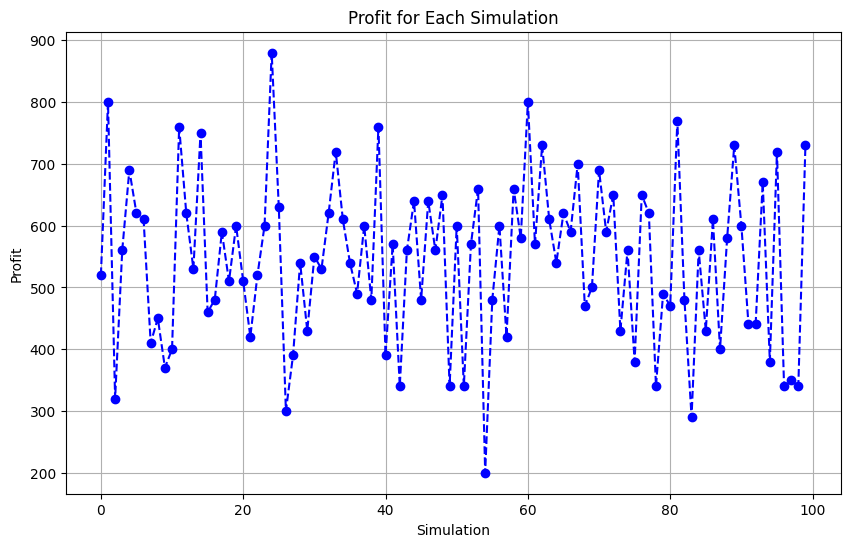

In [15]:
# Calculating revenue, cost, and profit for each simulation, adding to parsed_df, displaying basic financial statistics

# calculate the cost for each simulation
cost_list = []
for i in range(NUM_SIMULATIONS):
    cell_content = df.at[i, 'Event Log']
    server_wages = NUM_SERVERS * SERVER_WAGE * (SIMULATION_TIME / 60)
    cook_wages = NUM_COOKS * COOK_WAGE * (SIMULATION_TIME / 60)
    cost = server_wages + cook_wages
    cost_list.append(cost)

# add the cost list to the parsed_df DataFrame
parsed_df['Cost'] = cost_list

# calculate the revenue for each simulation
revenue_list = []
for i in range(NUM_SIMULATIONS):
    cell_content = df.at[i, 'Event Log']
    dinein_customers = cell_content.count(finished_eating_data)
    takeout_customers = cell_content.count(finished_takeout_data)
    dinein_revenue = REVENUE_PER_DINEIN * dinein_customers
    takeout_revenue = REVENUE_PER_TAKEOUT * takeout_customers
    revenue = dinein_revenue + takeout_revenue
    revenue_list.append(revenue)

# add the revenue list to the parsed_df DataFrame
parsed_df['Revenue'] = revenue_list

# calculate the profit for each simulation
profit_list = []
for i in range(NUM_SIMULATIONS):
    cell_content = df.at[i, 'Event Log']
    dinein_customers = cell_content.count(finished_eating_data)
    takeout_customers = cell_content.count(finished_takeout_data)
    server_wages = NUM_SERVERS * SERVER_WAGE * (SIMULATION_TIME / 60)
    cook_wages = NUM_COOKS * COOK_WAGE * (SIMULATION_TIME / 60)
    dinein_revenue = REVENUE_PER_DINEIN * dinein_customers
    takeout_revenue = REVENUE_PER_TAKEOUT * takeout_customers
    profit = dinein_revenue + takeout_revenue - server_wages - cook_wages
    profit_list.append(profit)

# add the profit list to the parsed_df DataFrame
parsed_df['Profit'] = profit_list

parsed_df.head()

# calculate the mean, median, and standard deviation of the profit
mean_profit = parsed_df['Profit'].mean()
median_profit = parsed_df['Profit'].median()
std_profit = parsed_df['Profit'].std()

# print out the mean, median, and standard deviation of the profit
print("Mean Profit: ", mean_profit)
print("Median Profit: ", median_profit)
print("Standard Deviation of Profit: ", std_profit)

# calculate the 95% confidence interval for the profit
confidence_interval = 1.96 * (std_profit / np.sqrt(NUM_SIMULATIONS))
lower_bound = mean_profit - confidence_interval
upper_bound = mean_profit + confidence_interval

# print out the 95% confidence interval for the profit
print("95% Confidence Interval for Profit: (", lower_bound, ",", upper_bound, ")")
print("\n")

# calculate the mean, median, and standard deviation of the revenue
mean_revenue = parsed_df['Revenue'].mean()
median_revenue = parsed_df['Revenue'].median()
std_revenue = parsed_df['Revenue'].std()

# print out the mean, median, and standard deviation of the revenue
print("Mean Revenue: ", mean_revenue)
print("Median Revenue: ", median_revenue)
print("Standard Deviation of Revenue: ", std_revenue)

# calculate the 95% confidence interval for the revenue
confidence_interval = 1.96 * (std_revenue / np.sqrt(NUM_SIMULATIONS))
lower_bound = mean_revenue - confidence_interval
upper_bound = mean_revenue + confidence_interval

# print out the 95% confidence interval for the revenue
print("95% Confidence Interval for Revenue: (", lower_bound, ",", upper_bound, ")")

# plot the profit for each simulation
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 6))
plt.plot(parsed_df['Simulation'], parsed_df['Profit'], marker = 'o', linestyle = '--', color = 'b')
plt.xlabel('Simulation')
plt.ylabel('Profit')
plt.title('Profit for Each Simulation')
plt.grid(True)
plt.show()